# Portfolio Backend

This notebook intends to build a python framework to manage your investment portfolio. 

We assume stocks are sold on a FIFO basis, although the functions defined in this notebook will be able to deal with other selling orders. We also assume that the price of a stock bought/sold is the closing market price of said stock on a given day. 

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns
from datetime import datetime

%matplotlib inline

In [2]:
transactions_path = "https://s3.amazonaws.com/www.yourdatasurfer.com/test_stock_transactions.csv"
investment_transactions = pd.read_csv(transactions_path)
investment_transactions['Open date'] = pd.to_datetime(investment_transactions['Open date'])
investment_transactions

,Symbol,Security,Qty,Type,Open date,Adj cost per share,Adj cost
0,AMZN,AMAZON COM INC,4,Buy,2014-01-06,390.870,1563.48
1,FB,FACEBOOK INC CL A,60,Buy,2014-01-06,54.790,3287.40
2,GLW,CORNING INC,100,Buy,2014-01-06,17.850,1784.99
3,GOOG,ALPHABET INC-CL C,2,Buy,2014-01-06,554.580,1109.16
4,GOOGL,ALPHABET INC-CL A,2,Buy,2014-01-06,557.890,1115.77
5,LNG,Cheniere Energy,30,Buy,2014-01-06,42.870,1286.10
6,FB,FACEBOOK INC CL A,13,Buy,2014-01-29,53.640,697.32
7,TSLA,TESLA INC,14,Buy,2014-02-18,204.160,2858.24
8,FB,FACEBOOK INC CL A,17,Buy,2014-04-23,61.710,1049.07
9,TSLA,TESLA INC,12,Buy,2014-09-16,258.340,3100.08


The next code block defines a series of functions that will be used throughout the notebook, especially for the objects Stock and Position. More functions will be added for building the portfolio and within the classes (objects) themselves.

In [3]:
def import_stock_data(tickers, start_date = '2010-1-1', end_date = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start_date, end = end_date)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start_date, end = end_date)['Adj Close']
    return data

def import_stock_dividends(tickers):
    """
    Fetches and returns the dividends of a given stock.
    Due to practical matters, this function will return all dividend history of a stock up until today.
    It cannot be subseted when imported.
    """
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo-dividends')['value']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo-dividends')['value']
    return data

def subset_by_dateindex(data, start_date=None, end_date=None, date_position="index"):
    """
    Subsets dataframe by dates (index)
    Inputs:
    start_date: (str) date FROM which to subset
    end_date: (str) date TO which to subset
    date_position: (str) index or name of column in which dates are 
    """
    if date_position != "index":
        data = data.set_index('Date')
        
    if (start_date == None) & (end_date == None):
        return data
    elif (start_date == None) & (end_date != None):
        return data[data.index <= end_date]
    elif (start_date != None) & (end_date == None):
        return data[data.index >= start_date]
    elif (start_date != None) & (end_date != None):
        return data[(data.index >= start_date) & (data.index <= end_date)]
    else:
        print("Wrong input")
        
def sell_order(purchase_history, sell_date, sell_quantity, order = "FIFO"):
    """
    Determines which stocks we are going to sell. 
    First in First Out? (FIFO)
    Last in First Out? (LIFO)
    Cheapest to Most Expensive? Low to High? (L2H)
    Most Expensive to Cheapest? High to Low? (H2L)
    """
    def purchase_history_edit(purchase_history, sell_date, sell_quantity):
        row_num = 0
        while sell_quantity != 0:
            ith_row = purchase_history.iloc[row_num]
            ith_quantity = ith_row.Shares
            if sell_quantity == ith_quantity:
                purchase_history.iloc[row_num, 1] = 0
                sell_quantity = 0
            elif (sell_quantity - ith_quantity) < 0:
                ith_quantity_left = abs(sell_quantity - ith_quantity)
                purchase_history.iloc[row_num, 1] = ith_quantity_left
                sell_quantity = 0
                row_num += 1
            elif (sell_quantity - ith_quantity) > 0:
                sell_quantity = sell_quantity - ith_quantity
                purchase_history.iloc[row_num, 1] = 0
                row_num += 1
        return purchase_history
    
    if order == "FIFO":
        purchase_history.sort_values(by='Date', ascending = True, inplace=True)
        return purchase_history_edit(purchase_history, sell_date, sell_quantity)
    
    elif order == "L2H":
        purchase_history.sort_values(by='Price', ascending = True, inplace=True)
        return purchase_history_edit(purchase_history, sell_date, sell_quantity)
    
    elif order == "LIFO":
        purchase_history.sort_values(by='Date', ascending = False, inplace=True)
        return purchase_history_edit(purchase_history, sell_date, sell_quantity)
    
    elif order == "L2H":
        purchase_history.sort_values(by='Price', ascending = False, inplace=True)
        return purchase_history_edit(purchase_history, sell_date, sell_quantity)
    

Great! Now that we have defined functions to (1) import historical data for any stock, (2) import historical dividends of stock, (3) subset any dataframe by date (at index position), and (4) define the order in which stocks will be sold (default FIFO), let's make our first class: **Stock**.

In [4]:
class Stock:
    # This class will define the information of a stock
    def __init__(self, ticker):
        self.ticker = ticker
        self.historical_data = import_stock_data(self.ticker, start_date="1970-1-1")
        self.historical_daily_returns = ((self.historical_data/self.historical_data.shift(1))-1)
        try:
            self.dividends = import_stock_dividends(self.ticker)
        except:
            self.dividends = pd.DataFrame({"value":0}, index=['1970-1-1'])
        
    def __str__(self):
        return self.ticker
        
    def plot_stock(self, start_date=None, end_date=None):
        return subset_by_dateindex(self.historical_data, start_date=start_date, end_date=end_date).plot(figsize=(15,8))

Let's see how it works.

We simply define the ticker of the stock and the class will load the data from the earliest date, until today. We can also use the plot_stock method to plot the prices of the given stock between two specified dates. 

In [5]:
aapl = Stock('AAPL')
aapl.historical_data

,AAPL
Date,
1980-12-12,0.405683
1980-12-15,0.384517
1980-12-16,0.356296
1980-12-17,0.365115
1980-12-18,0.375698
...,...
2020-06-25,364.839996
2020-06-26,353.630005
2020-06-29,361.779999


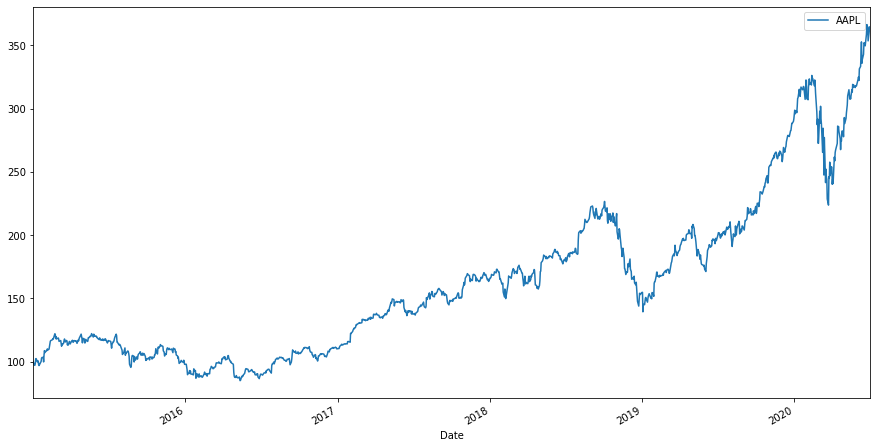

In [6]:
aapl.plot_stock(start_date="2015-1-1")

Now, we would like to know what our position of a given stock is. Let's define said class as **Position**.

This class is quite important, since it must contain methods to update the values (ex - equity) of a position on any given day, and update the data regarding your position if you buy or sell a number of stocks on a given day.

Hence, this class contain three methods that are of paramount importance:
* .buy(),
* .sell(),
* .update()

The only things needed to use these methods are the quantity of stocks bought/sold and the date (date when the market IS open)

In [7]:
class Position:
    def __init__(self, Stock):
        self.stock = Stock
        self.shares = 0
        self.equity = 0
        self.invested = 0
        self.market_price = np.nan
        self.unrealized_gain = 0
        self.realized_gain = 0
        self.cash_on_hand = np.nan
        self.purchase_history = pd.DataFrame(columns=["Date","Shares","Price"])
        self.ownership_history = pd.DataFrame(columns=["Date","Ticker","Market_Price",
                                                       "Shares","Equity","Invested",
                                                       "Unrealized_Gains","Realized_Gains",
                                                       "Gains"])
    
    def __str__(self):
        return "Position for {}".format(self.stock.ticker)
        
    def buy(self, quantity, date):
        self.shares = self.shares + quantity
        self.market_price = subset_by_dateindex(self.stock.historical_data, date, date).iloc[0][0]
        self.invested = self.invested + (quantity*self.market_price)
        self.equity = self.shares*self.market_price
        self.unrealized_gain = self.equity - self.invested
        self.purchase_history = self.purchase_history.append({"Date":date,"Shares":quantity,"Price":self.market_price}, ignore_index=True)
        
        #Realized gains including dividends
        if date in self.stock.dividends.index:
            self.realized_gain = self.realized_gain + (self.shares * subset_by_dateindex(self.stock.dividends, date, date).iloc[0][0])
        
        #Update ownership history - a dataframe with all relevant stats for every day
        self.ownership_history = self.ownership_history.append({"Date":date,"Ticker":self.stock.ticker,"Market_Price":self.market_price,
                                                               "Shares":self.shares,"Equity":self.equity,"Invested":self.invested,
                                                               "Unrealized_Gains":self.unrealized_gain, "Realized_Gains":self.realized_gain,
                                                               "Gains":(self.unrealized_gain + self.realized_gain)}, ignore_index=True)
        
    def sell(self, quantity, date):
        self.shares = self.shares - quantity
        self.market_price = subset_by_dateindex(self.stock.historical_data, date, date).iloc[0][0]
        self.equity = self.shares*self.market_price    
        self.purchase_history = sell_order(self.purchase_history, date, quantity)
        invested_prior_to_sell = self.invested
        self.invested = sum(self.purchase_history[['Shares','Price']].prod(axis=1))
        self.unrealized_gain = self.equity - self.invested
        self.realized_gain = self.realized_gain + ((quantity*self.market_price)-(invested_prior_to_sell-self.invested))

        #Realized gains including dividends
        if date in self.stock.dividends.index:
            self.realized_gain = self.realized_gain + (self.shares * subset_by_dateindex(self.stock.dividends, date, date).iloc[0][0]) + ((quantity*self.market_price)-(invested_prior_to_sell-self.invested))
        else:
            self.realized_gain = self.realized_gain + ((quantity*self.market_price)-(invested_prior_to_sell-self.invested))
        
        #Update ownership history - a dataframe with all relevant stats for every day
        self.ownership_history = self.ownership_history.append({"Date":date,"Ticker":self.stock.ticker,"Market_Price":self.market_price,
                                                               "Shares":self.shares,"Equity":self.equity,"Invested":self.invested,
                                                               "Unrealized_Gains":self.unrealized_gain, "Realized_Gains":self.realized_gain,
                                                               "Gains":(self.unrealized_gain + self.realized_gain)}, ignore_index=True)
        
        
    def update(self, date):
        self.market_price = subset_by_dateindex(self.stock.historical_data, date, date).iloc[0][0]
        self.equity = self.shares * self.market_price
        self.unrealized_gain = self.equity - self.invested        

        #Realized gains including dividends
        if date in self.stock.dividends.index:
            self.realized_gain = self.realized_gain + (self.shares * subset_by_dateindex(self.stock.dividends, date, date).iloc[0][0])
        
        #Update ownership history - a dataframe with all relevant stats for every day
        self.ownership_history = self.ownership_history.append({"Date":date,"Ticker":self.stock.ticker,"Market_Price":self.market_price,
                                                               "Shares":self.shares,"Equity":self.equity,"Invested":self.invested,
                                                               "Unrealized_Gains":self.unrealized_gain, "Realized_Gains":self.realized_gain,
                                                               "Gains":(self.unrealized_gain + self.realized_gain)}, ignore_index=True)
        
        

Let's continue with out AAPL example above. Say we bouth 10 stocks on 2017-3-2

In [8]:
aapl_pos = Position(aapl)
aapl_pos.buy(10, "2017-3-2")
print(f"The number of shares is {aapl_pos.shares}")
print(f"The market price at which the stocks were bought is ${aapl_pos.market_price}")
print(f"Your equity of the stock is ${aapl_pos.equity}")
print(f"Your unrealized gain/loss is ${aapl_pos.unrealized_gain}")
aapl_pos.ownership_history

The number of shares is 10
The market price at which the stocks were bought is $132.64425659179688
Your equity of the stock is $1326.4425659179688
Your unrealized gain/loss is $0.0


,Date,Ticker,Market_Price,Shares,Equity,Invested,Unrealized_Gains,Realized_Gains,Gains
0,2017-3-2,AAPL,132.644257,10,1326.442566,1326.442566,0.0,0,0.0


As you guessed, this is stating the information based on the day of purchase. What does that mean? There is no unrealized gain or loss, and all the information is static from the date you purchased said stocks. So, let's update our position for the next day!

In [9]:
aapl_pos.update("2017-3-3")
print(f"The number of shares is {aapl_pos.shares}")
print(f"The market price the day after the stocks were bought is ${aapl_pos.market_price}")
print(f"Your equity of the stock is ${aapl_pos.equity}")
print(f"Your unrealized gain/loss is ${aapl_pos.unrealized_gain}")
aapl_pos.ownership_history

The number of shares is 10
The market price the day after the stocks were bought is $133.4269561767578
Your equity of the stock is $1334.2695617675781
Your unrealized gain/loss is $7.826995849609375


,Date,Ticker,Market_Price,Shares,Equity,Invested,Unrealized_Gains,Realized_Gains,Gains
0,2017-3-2,AAPL,132.644257,10,1326.442566,1326.442566,0.000000,0,0.000000
1,2017-3-3,AAPL,133.426956,10,1334.269562,1326.442566,7.826996,0,7.826996


In just one day, our position has increased by $7.8. What is we sold half of our equity the day afterwards?

In [10]:
aapl_pos.sell(5,"2017-3-6")
print(f"The number of shares is {aapl_pos.shares}")
print(f"The market price two days after the stocks were bought is ${aapl_pos.market_price}")
print(f"Your equity of the stock is ${aapl_pos.equity}")
print(f"Your unrealized gain/loss is ${aapl_pos.unrealized_gain}")
aapl_pos.ownership_history

The number of shares is 5
The market price two days after the stocks were bought is $133.0069580078125
Your equity of the stock is $665.0347900390625
Your unrealized gain/loss is $1.813507080078125


,Date,Ticker,Market_Price,Shares,Equity,Invested,Unrealized_Gains,Realized_Gains,Gains
0,2017-3-2,AAPL,132.644257,10,1326.442566,1326.442566,0.000000,0,0.000000
1,2017-3-3,AAPL,133.426956,10,1334.269562,1326.442566,7.826996,0,7.826996
2,2017-3-6,AAPL,133.006958,5,665.034790,663.221283,1.813507,3.62701,5.440521


Our equity has almost halved! This makes sense since we sold half of the shares. Our unrealized gains also dropped significantly. This is because half of the unrealized gains became realized gains, and the rest devalued due to the drop of the market price today.


Alright alright... you get it! 

The next block defined functions to load the portfolio and get the portfolio data for a specified feature. What does this mean? 

Loading the portfolio is simply creating a Position object for every stock in our portfolio (defined by the csv imported above) and updating it every day from the first purchase until today. 

Note that the names of the columns of your personal csv file with your transactions must match the imported one above. That is, the ticker column's name is Symbol, the quantity is Qty, etc.

In [11]:
def load_portfolio(transactions):
    """
    Loads portfolio object from a dataframe of transactions.
    Requires the Stock and Position objects.
    Returns a dictionary with the position of every stock in the portfolio.
    """
    stocks = transactions.Symbol.unique()
    stock_dict = dict(zip(stocks, [None]*len(stocks)))
    for stock_name in stocks:
        stock_transactions = transactions[transactions['Symbol'] == stock_name]
        earliest_date = min(stock_transactions['Open date'])
        position = Position(Stock(stock_name))
        stock_dates = position.stock.historical_data.index
        for day_active_market in list(stock_dates[stock_dates >= earliest_date]):
            day_transaction = stock_transactions[stock_transactions['Open date'] == str(day_active_market)]
            if len(day_transaction) == 1:
                purchase_type = day_transaction.Type.values
                quantity = day_transaction.Qty.values[0]
                if purchase_type == "Buy":
                    position.buy(quantity, day_active_market)
                    print(f"You bought {quantity} shares of {stock_name} on {str(day_active_market)[:10]} for ${round(position.market_price,2)}")
                else:
                    position.sell(quantity, day_active_market)
                    print(f"You sold {quantity} shares of {stock_name} on {str(day_active_market)[:10]} for ${round(position.market_price,2)}")
            else:
                position.update(day_active_market)
        stock_dict[stock_name] = position
    return stock_dict

def get_portfolio_feature_data(portfolio, feature, return_type = 'perStock'):
    """
    Returns dataframe with the specified feature of each stock or a combination of all stocks
    Input:
    1. portfolio: a Portfolio object
    2. feature: the feature in the ownership_history dataframe within a portfolio object to return
    3. return_type: either 'perStock' or 'combined' - returns a dataframes with the features with a column for every stock or a summation of the values of all stocks
    """
    stocks = list(portfolio.stock_positions.keys())
    df_to_return = pd.DataFrame()
    for s in stocks:
        stock_column = portfolio.stock_positions[s].ownership_history.set_index('Date')[[feature]].rename(columns={feature:s})
        stock_column.replace(0,np.nan,inplace=True)
        df_to_return = pd.concat([df_to_return, stock_column], sort=False, axis=1)
    if return_type == 'perStock':
        return df_to_return
    elif return_type == 'combined':
        string = "Total_"+str(feature)
        return pd.DataFrame(df_to_return.sum(axis=1), columns=[string])
    return df_to_return

Now that these functions have been defined, let's create our **Portfolio** object!

All it will need for an input is the csv imported above.

In [12]:
class Portfolio:
    def __init__(self, transactions):
        self.stock_positions = load_portfolio(transactions)
        
    def plot_portfolio_feature(self, feature):
        return get_portfolio_feature_data(self, feature, return_type='combined').plot(figsize=(15,8))
    
    def plot_feature_perStock(self, feature):
        return get_portfolio_feature_data(self, feature, return_type='perStock').plot(figsize=(15,8))
    
    def plot_portfolio(self):
        invested = get_portfolio_feature_data(self, 'Invested', 'combined')
        maxinvested = max(invested['Total_Invested'])
        combined_return = get_portfolio_feature_data(self, 'Gains', 'combined')/maxinvested
        return combined_return.plot(figsize=(15,8))
        
    def portfolio_from_to(self, start_date=None, end_date=None, market_ticker = "^GSPC"):
        invested = get_portfolio_feature_data(self, 'Invested', 'combined')
        invested = subset_by_dateindex(invested, start_date, end_date)
        maxinvested = max(invested['Total_Invested'])
        unr_gain_at_dates = subset_by_dateindex(get_portfolio_feature_data(self, 'Gains', 'combined'), start_date, end_date)
        print(unr_gain_at_dates)
        adj_gains = unr_gain_at_dates-unr_gain_at_dates.iloc[0]
        combined_return = adj_gains/maxinvested
        
        if start_date == None:
            start_date = min(unr_gain_at_dates.index)
        market = import_stock_data(market_ticker, start_date, end_date)
        adj_market = market-market.iloc[0]
        
        with_market = combined_return
        with_market[market_ticker] = adj_market/market.iloc[0]
        
        ret_dataframe = pd.DataFrame({"Portfolio":[f"${round(adj_gains.iloc[-1][0],2)}",
                                                   f"{round(combined_return.iloc[-1][0]*100,2)}%"],
                                     "Market":[' ',
                                               f"{round((100*adj_market/market.iloc[0]).iloc[-1][0],2)}%"]}, 
                                     index=['Gains','Return'])
        
        #Show Plot
        with_market.plot(figsize=(15,8))
        plt.show()
        
        return ret_dataframe
    

In [13]:
facebook_transactions = pd.DataFrame({"Symbol":["FB","FB","FB"],
                        "Qty":[100,100,50],
                        "Type":["Buy","Buy","Sell"],
                        "Open date":[datetime(2020, 1,2),datetime(2020,2,3),datetime(2020,2,18)]})

In [14]:
facebook_transactions

,Symbol,Qty,Type,Open date
0,FB,100,Buy,2020-01-02
1,FB,100,Buy,2020-02-03
2,FB,50,Sell,2020-02-18


In [15]:
myP_FB = Portfolio(facebook_transactions)

You bought 100 shares of FB on 2020-01-02 for $209.78
You bought 100 shares of FB on 2020-02-03 for $204.19
You sold 50 shares of FB on 2020-02-18 for $217.8


            Total_Gains
Date                   
2020-01-02     0.000000
2020-01-03  -111.000061
2020-01-06   282.000732
2020-01-07   327.999878
2020-01-08   544.000244
2020-01-09   852.000427
2020-01-10   827.999878
2020-01-13  1213.000488
2020-01-14   927.999878
2020-01-15  1136.999512
2020-01-16  1199.000549
2020-01-17  1236.000061
2020-01-21  1166.000366
2020-01-22  1154.000854
2020-01-23   997.999573
2020-01-24   816.000366
2020-01-27   508.999634
2020-01-28   800.999451
2020-01-29  1344.999695
2020-01-30   -25.000000
2020-01-31  -786.999512
2020-02-03  -558.999634
2020-02-04   569.000244
2020-02-05   625.000000
2020-02-06   773.001099
2020-02-07  1069.000244
2020-02-10  1214.999390
2020-02-11    41.000366
2020-02-12   754.998779
2020-02-13  1230.999756
2020-02-14  1438.998413
2020-02-18  2564.000702
2020-02-19  2517.501068


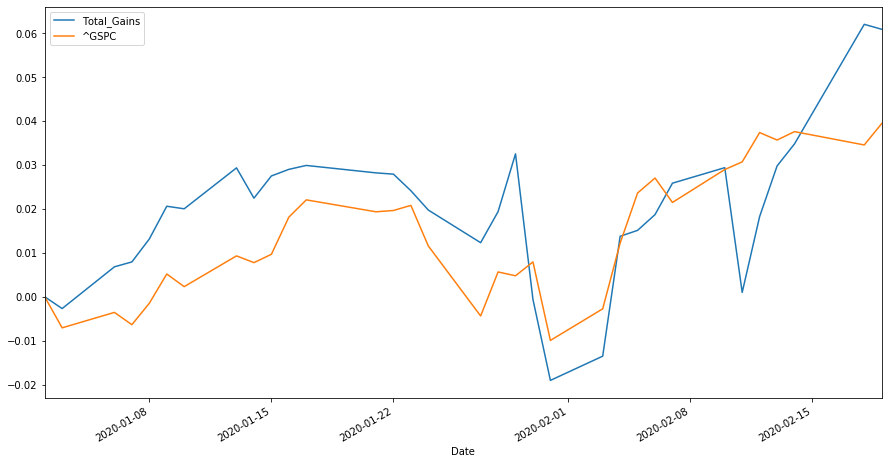

,Portfolio,Market
Gains,$2517.5,
Return,6.08%,3.94%


In [16]:
myP_FB.portfolio_from_to(end_date = "2020-02-19")

In [18]:
my_portfolio = Portfolio(investment_transactions)

You bought 4 shares of AMZN on 2014-01-06 for $393.63
You bought 3 shares of AMZN on 2017-04-27 for $918.38
You bought 60 shares of FB on 2014-01-06 for $57.2
You bought 13 shares of FB on 2014-01-29 for $53.53
You bought 17 shares of FB on 2014-04-23 for $61.36
You bought 4 shares of FB on 2014-12-31 for $78.02
You sold 13 shares of FB on 2018-06-22 for $201.74
You bought 100 shares of GLW on 2014-01-06 for $15.11
You bought 2 shares of GOOG on 2014-01-06 for $556.57
You bought 2 shares of GOOGL on 2014-01-06 for $559.22
You bought 30 shares of LNG on 2014-01-06 for $43.3
You sold 30 shares of LNG on 2017-09-15 for $43.62
You bought 14 shares of TSLA on 2014-02-18 for $203.7
You bought 12 shares of TSLA on 2014-09-16 for $260.74
You bought 30 shares of AAPL on 2015-08-26 for $101.55
You bought 22 shares of AAPL on 2017-09-27 for $148.41
You bought 10 shares of NFLX on 2016-06-30 for $91.48
You bought 100 shares of NVDA on 2017-09-18 for $185.98
You bought 200 shares of OSTK on 2017-10

             Total_Gains
Date                    
2014-01-06      0.000000
2014-01-07    170.498196
2014-01-08    252.526737
2014-01-09    168.641579
2014-01-10    226.043674
...                  ...
2020-06-25  88288.556098
2020-06-26  82979.469000
2020-06-29  85242.734831
2020-06-30  89783.748442
2020-07-01  92979.303473

[1634 rows x 1 columns]


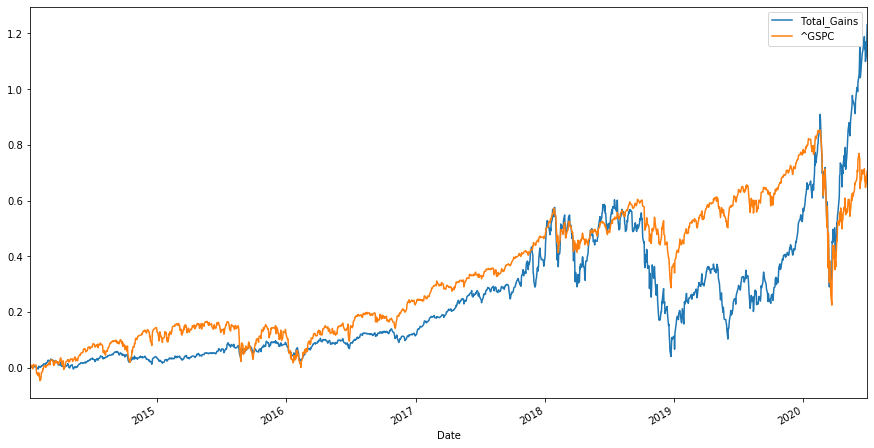

,Portfolio,Market
Gains,$92979.3,
Return,123.19%,70.65%


In [19]:
my_portfolio.portfolio_from_to()

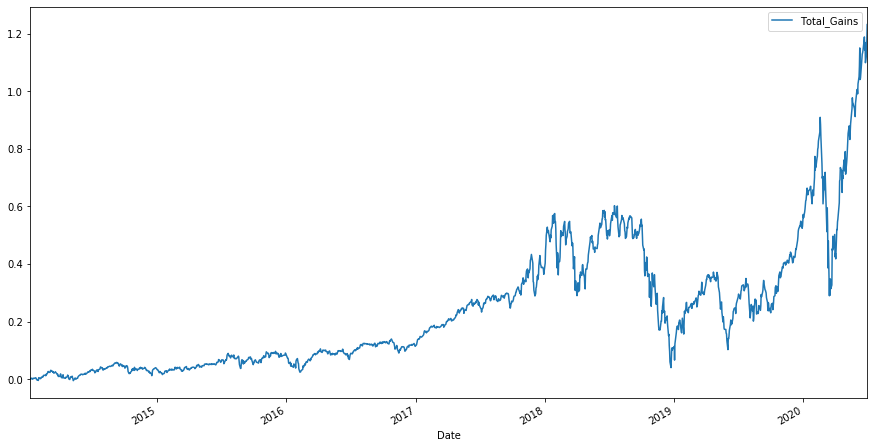

In [20]:
my_portfolio.plot_portfolio()

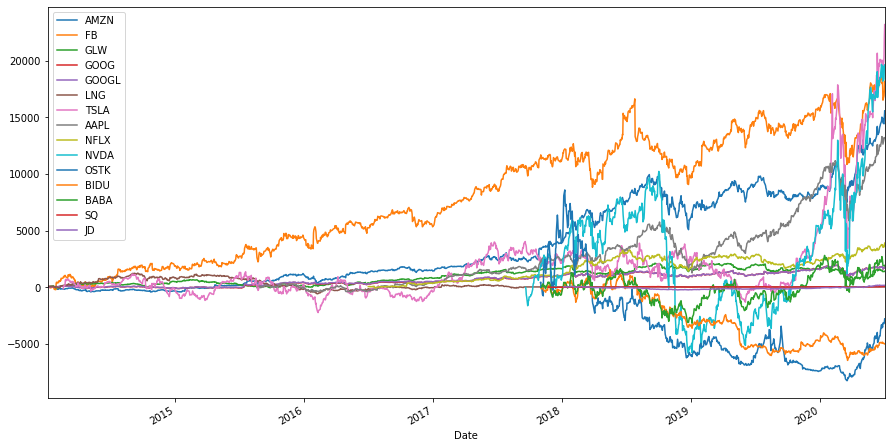

In [21]:
my_portfolio.plot_feature_perStock('Gains')

Let's check whether the integration of dividends worked.

Let's take into consideration AAPL. AAPL has given dividends since 2015. We can see that below.

In [22]:
import_stock_dividends('AAPL')

,AAPL
2020-05-08,0.82
2020-02-07,0.77
2019-11-07,0.77
2019-08-09,0.77
2019-05-10,0.77
2019-02-08,0.73
2018-11-08,0.73
2018-08-10,0.73
2018-05-11,0.73
2018-02-09,0.63


In our current portfolio, we have bought AAPL twice. Once in 2015 for \$102 per share (30 shares total) and the second time in 2017 for \$148 per share (22 shares: 52 shares total). We have **not** sold AAPL once. 

What does this entail? Well, if we have not sold AAPL at any point, we should not have any unrealized gains, except those that are generated through dividends!

In [23]:
my_portfolio.stock_positions['AAPL'].purchase_history

,Date,Shares,Price
0,2015-08-26,30,101.548851
1,2017-09-27,22,148.408386


In [24]:
my_portfolio.stock_positions['AAPL'].ownership_history

,Date,Ticker,Market_Price,Shares,Equity,Invested,Unrealized_Gains,Realized_Gains,Gains
0,2015-08-26,AAPL,101.548851,30,3046.465530,3046.465530,0.000000,0,0.000000
1,2015-08-27,AAPL,104.539131,30,3136.173935,3046.465530,89.708405,0,89.708405
2,2015-08-28,AAPL,104.881653,30,3146.449585,3046.465530,99.984055,0,99.984055
3,2015-08-31,AAPL,104.390999,30,3131.729965,3046.465530,85.264435,0,85.264435
4,2015-09-01,AAPL,99.725060,30,2991.751785,3046.465530,-54.713745,0,-54.713745
...,...,...,...,...,...,...,...,...,...
1216,2020-06-25,AAPL,364.839996,52,18971.679810,6311.450027,12660.229782,557.56,13217.789782
1217,2020-06-26,AAPL,353.630005,52,18388.760254,6311.450027,12077.310226,557.56,12634.870226
1218,2020-06-29,AAPL,361.779999,52,18812.559937,6311.450027,12501.109909,557.56,13058.669909
1219,2020-06-30,AAPL,364.799988,52,18969.599365,6311.450027,12658.149338,557.56,13215.709338


As we can see from the ownership history of AAPL in our portfolio, we have realized gains! This means that dividends are being computed, and that we have generated \$560 from dividends.